In [42]:
# Load in the old results in the h5ad format as a template for loading in new data later
adata = sc.read_h5ad(master_dir + 'output/adata_integrated_corr_only_test_temp.h5ad')
adata

AnnData object with n_obs × n_vars = 242 × 839
    obs: 'source_label', 'observation_id', 'incov_redcap_event_name', 'observation_days_since_enrollment', 'abdominal_pain', 'ambulatory', 'blood_draw_status', 'blood_draw_status_bad', 'blood_draw_type', 'blood_oxygenation', 'blood_oxygenation_max', 'blood_oxygenation_min', 'chest_xray_ct', 'cough', 'diarrhea', 'diastolic_bp', 'dypsnea', 'dysgeusia', 'ecmo', 'fatigue', 'height', 'mechanical_ventilation', 'nausea_vomiting', 'new_dialysis_need', 'new_vaspressor_need', 'patient_location', 'pulse', 'respiratory_rate', 'respiratory_support', 'sputum', 'systolic_bp', 'temperature', 'temperature_max', 'temperature_min', 'weight', 'who_ordinal_scale', 'sample_id', 'kmeans2', 'kmeans3', 'kmeans4', 'time_wrt_Remdesivir (RDV)', 'time_wrt_Tocilizumab', 'time_wrt_Vitamin C', 'time_wrt_Zinc', 'time_wrt_Hydroxychloroquine (HCQ)', 'time_wrt_HCQ + Azithromycin', 'time_wrt_Steroid', 'time_wrt_Other', 'time_wrt_Plasma Transfusions', 'severity', 'severity_T1'

In [43]:
# Also load in the new INCOV data, which is in Excel format
new_data = pd.read_csv(master_dir + 
            'data/validation_metabolites/new validation data March 2021/metabolomics_corrected_2021-03-18.tsv',
                      sep='\t')
chem_matching = pd.read_csv(master_dir + 
            'data/validation_metabolites/new validation data March 2021/metabolomics_metadata_2021-03-18.tsv',
                      sep='\t')

In [44]:
chem_matching.index = chem_matching['CHEMICAL_ID']
s = chem_matching['BIOCHEMICAL_NAME']
s.index = s.index.astype(str)
new_data = new_data.rename(columns=s.to_dict())
new_data.index = new_data['sample_id']

In [45]:
# The following are sample identifiers for the old and new datasets
set(new_data['sample_id']).difference(set(adata.obs.index))

{'A007BG406-003',
 'A007BG415-003',
 'A007BG431-003',
 'A007BG455-006',
 'A007BG473-003',
 'A007BG481-003',
 'A007BG492-006',
 'A007BG497-003',
 'A020BJ241-002',
 'A020BJ291-009',
 'A020BJ361-009',
 'A020BJ365-002',
 'A020BJ370-002',
 'A020BJ380-002',
 'A055BH105-007',
 'A132BK186-002',
 'A132BK188-002',
 'A132BK229-007',
 'A132BK243-005',
 'A132BK337-007',
 'A137BG433-008',
 'A137BG437-003',
 'A137BG446-012',
 'A137BG457-003',
 'A137BG462-003',
 'A137BG471-010',
 'A137BG472-010',
 'A146BJ690-011',
 'A146BJ713-002',
 'A146BJ717-002',
 'A146BJ738-002',
 'A146BJ773-002',
 'A146BJ775-005',
 'A168BH878-003',
 'A168BH881-003',
 'A168BH919-003',
 'A168BH929-003',
 'A168BH932-004',
 'A168BH962-003',
 'A168BH964-003',
 'A168BH968-003',
 'A168BH970-008',
 'A168BH986-008',
 'A179BJ685-006',
 'A179BJ687-009',
 'A265BK922-002',
 'A265BK939-002',
 'A265BK959-009',
 'A286BI347-003',
 'A286BI586-003',
 'A286BI592-003',
 'A286BI604-007',
 'A308BH386-003',
 'A308BH400-003',
 'A308BH427-003',
 'A308BH43

In [46]:
set(adata.obs.index).difference(set(new_data['sample_id'])) 
# No remaining samples, so the new dataset has all of the old samples also

set()

In [47]:
# The below command has already been run
#new_data.to_csv(master_dir + 
#            'data/validation_metabolites/new validation data March 2021/metabolomics_corrected_2021-03-18'
#                + '_with-chem-names.csv')

In [48]:
old_only_vars = set(adata.var_names).difference(set(new_data.columns))

In [49]:
# As seen above, all metabolite names match, and the only var_names that don't match are the
# cell type-specific activities

# Run this cell if testing: replace the old, non-batch-corrected values with the new, batch-corrected values
# keeping only the same samples as before
adata_batch_corrected = adata.copy()
adata_batch_corrected = adata_batch_corrected[:, 
                                list(set(adata_batch_corrected.var_names).difference(old_only_vars))]
adata_batch_corrected.X = new_data.loc[adata_batch_corrected.obs.index.values, 
                                       adata_batch_corrected.var_names.values]
adata = adata_batch_corrected

In [50]:
class train_test:
    # For storing the machine, training set, testing set, and prediction
    def __init__(self, pre_clf, selected_features, clf, 
                 X_train, X_test, y_train, y_test, prediction, score):
        self.pre_clf = pre_clf
        self.selected_features = selected_features
        self.clf = clf
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.prediction = prediction
        self.score = score

In [51]:
dead = pd.read_excel(master_dir + 'data/dead_patients.xlsx')
dead = dead.set_index('source_label')
dead.head()

,death
source_label,
INCOV001,No
INCOV002,No
INCOV003,No
INCOV004,Yes
INCOV005,No


In [52]:
# The below command has already been run
#temp = PCA_list.copy()
#temp.append('sample_id')
#new_data.loc[:, temp].to_csv(master_dir + 
#            'data/validation_metabolites/new validation data March 2021/metabolomics_corrected_2021-03-18'
#                + '_with-chem-names_PCA-only.csv')

In [53]:
def impute_input(adata_, output_, output_resampled_):
    # Instead of dropping metabolites with nans, try imputing
    # 1) Winsorize data
    # 2) Impute data
    # 3) Normalize data
    input_pre = winsorize(adata_[output_.index, PCA_list].X.copy(), axis=1, limits=[0.05, 0.05])
    input_pre = pd.DataFrame(input_pre)
    input_pre.columns = PCA_list
    input_pre.index = output_.index

    imputer = IterativeImputer(max_iter=10, random_state=0)
    input_pre_new = pd.DataFrame(imputer.fit_transform(input_pre))
    nanmask = ~np.isnan(imputer.initial_imputer_.statistics_) # In case a column is entirely NaN values, it's removed from the transform
    
    input_pre_new.columns = np.array(PCA_list)[np.where(nanmask)[0]]
    input_pre_new.index = input_pre.index
    input_pre[input_pre_new.columns] = input_pre_new.copy() # Filling in the imputed values
    input_pre = input_pre.fillna(0) 
    
    # Normalize as we did before 
    tempX = (input_pre - np.mean(input_pre, axis=0)) / \
            (np.max(input_pre, axis=0) - np.min(input_pre, axis=0)) 

    input_pre = tempX
    input_pre = input_pre.fillna(0)

    input_pre = input_pre.loc[output_resampled_.index]
    
    return input_pre

In [54]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, max_features='sqrt', 
                             max_depth=50, min_samples_leaf=1, min_samples_split=2, random_state=0, n_jobs=-1)

output = adata.obs[adata.obs['who_change_cat']!='nan'][['blood_draw_type', 'who_change_cat', 'who_change']]
output = output[output['blood_draw_type']=='Baseline']
output['death'] = dead.reindex([x.split('-')[0] for x in output.index])['death'].tolist()
output['who_change_cat'] = ['Better/Stable' if x < 0 else 'Better/Stable' if x==0 
                            else 'Worse/Died' for x in output['who_change']]

for i in output.index:
    if output.loc[i, 'death']=='Yes':
        output.loc[i, 'who_change_cat'] = 'Worse/Died'
output_pre = output.copy()
output = output['death'].dropna().astype(str)

PCA_list = ['5alpha-androstan-3alpha,17beta-diol disulfate',
                                   'alpha-ketobutyrate', 
                                   'arachidonoyl ethanolamide', 
                                   '2-hydroxybutyrate/2-hydroxyisobutyrate', 
                                   'acetoacetate', 
                                   '2-hydroxysebacate', 
                                   '7-methylxanthine', 
                                   'N,N-dimethylalanine', 
                                   'glycine conjugate of C10H12O2*',
                                   'pyroglutamylglutamine',
                                   'palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*',
                                   'maltose', 
                                   'N-palmitoyl-sphingosine (d18:1/16:0)',
                                   '1-palmitoyl-2-oleoyl-GPE (16:0/18:1)',
                                   '1-oleoyl-2-linoleoyl-GPE (18:1/18:2)*',
                                   '1,5-anhydroglucitol (1,5-AG)',
                                   'bilirubin (E,Z or Z,E)*',
                                   'cysteine-glutathione disulfide', 
                                   'tryptophan',
                                   'bilirubin (E,E)*']

In [55]:
# Test the above trained model on the new INCOV dataset and the JWCI dataset separately
# New INCOV data already imported (except live-dead data). Live-dead data import below
new_INCOV_dead = pd.read_excel(master_dir + 'data/dead_patients-INCOV_JWCI-210318.xlsx', sheet_name='INCOV')
new_INCOV_dead = new_INCOV_dead['source_label']

# Importing JWCI data
JWCI_dead = pd.read_excel(master_dir + 'data/dead_patients-INCOV_JWCI-210318.xlsx', sheet_name='JWCI')
JWCI_dead = JWCI_dead['PatientID']

In [56]:
# Make a new AnnData containing the JWCI data only
JWCI_pts = new_data[new_data['public_client_id'].str.startswith('JWCI')]
JWCI_pts = JWCI_pts[JWCI_pts['sample_id'].str.contains('T1')]
dead_JWCI = pd.DataFrame(JWCI_pts['public_client_id'].copy())
dead_JWCI = dead_JWCI.set_index('public_client_id')
dead_JWCI['death'] = ['Yes' if x in JWCI_dead.values else 'No' for x in JWCI_pts['public_client_id']]

adata_JWCI = sc.AnnData(X=np.empty([len(JWCI_pts), len(adata.var)]), var=adata.var)
adata_JWCI.obs = JWCI_pts.iloc[:, :2]
adata_JWCI.obs['death'] = dead_JWCI.loc[adata_JWCI.obs['public_client_id']].values
adata_JWCI.X = new_data.loc[adata_JWCI.obs.index, adata_JWCI.var_names]
adata_JWCI.obs = adata_JWCI.obs.set_index('public_client_id')

### New INCOV data

In [58]:
# Make a new AnnData containing the new INCOV data only
new_pts = new_data[new_data['public_client_id'].str.startswith('INCOV')]
new_pts = new_pts.loc[[x not in adata.obs.index.values for x in new_pts['sample_id']]]
new_pts = new_pts[new_pts['sample_id'].str.contains('BL')]
dead_new = pd.DataFrame(new_pts['public_client_id'].copy())
dead_new = dead_new.set_index('public_client_id')
dead_new['death'] = ['Yes' if x in new_INCOV_dead.values else 'No' for x in new_pts['public_client_id']]

adata_new = sc.AnnData(X=np.empty([len(new_pts), len(adata.var)]), var=adata.var)
adata_new.obs = new_pts.iloc[:, :2]
adata_new.obs['death'] = dead_new.loc[adata_new.obs['public_client_id']].values
adata_new.X = new_data.loc[adata_new.obs.index, adata_new.var_names]
adata_new.obs = adata_new.obs.set_index('public_client_id')

In [59]:
# Load in new INCOV patient clinical data
new_pts_obs = pd.read_excel(master_dir + 
                            'data/validation_metabolites/new validation data March 2021/new INCOV/observations_2021-03-29_1330-T1_only.tsv.xlsx',
                           sheet_name='T1 only')

In [60]:
new_pts_obs.index = new_pts_obs['source_label']

In [61]:
adata_new.obs['patient_location'] = new_pts_obs.loc[adata_new.obs.index, 'patient_location']
adata_new.obs['who_ordinal_scale'] = new_pts_obs.loc[adata_new.obs.index, 'who_ordinal_scale']
adata_new.obs['who_ordinal_scale'] = [1.5 if x=='1 or 2' else x for x in adata_new.obs['who_ordinal_scale']]
adata_new.obs['who_ordinal_scale'] = adata_new.obs['who_ordinal_scale'].astype(float)

In [62]:
# Test the previously old INCOV-trained model on the new INCOV dataset
# If reapplying same model without retraining
output_new = dead_new['death']

/home/jwlee/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


### Combined new INCOV and old INCOV for training

In [63]:
# Hyperparameter tuning
#from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(2, 100, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,}
#               #'bootstrap': bootstrap}

#rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [64]:
adata_comb = sc.AnnData.concatenate(adata, adata_new, index_unique=None)
output_comb = pd.concat([output, output_new])
adata_comb.obs = pd.concat([adata.obs, adata_new.obs])[['patient_location', 'who_ordinal_scale']]

adata_comb = adata_comb[output_comb.index]
adata_comb = adata_comb[adata_comb.obs['patient_location']!='Home (mobile phlebotomy)']
adata_comb = adata_comb[adata_comb.obs['patient_location']!='Clinic']
output_comb = output_comb[adata_comb.obs.index]

# Separate majority and minority classes
output_majo = output_comb[output_comb=='No']
output_mino = output_comb[output_comb=='Yes']
 
# Resample minority class (dead) to fixed fraction of majority class (surviving)
output_mino_resampled = resample(output_mino, replace=True, n_samples=int(len(output_majo)/5), random_state=42)
 
# Combine majority class with resampled minority class
output_resampled = pd.concat([output_majo, output_mino_resampled])

input_t1_pre = impute_input(adata_comb, output_comb, output_resampled)

/home/jwlee/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [65]:
param_grid = {
    'bootstrap': [False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [500]
}
erf = ExtraTreesClassifier()
grid_search = GridSearchCV(estimator = erf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(input_t1_pre, output_resampled)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   27.6s finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [66]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 10, 15, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200, 300, 400, 500]
}
# Create a based model
pre_clf = ExtraTreesClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features='auto',
                              min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=20)
pre_clf = pre_clf.fit(input_t1_pre, output_resampled)
importances = pre_clf.feature_importances_
model = SelectFromModel(pre_clf, threshold='1.1*mean', prefit=True, max_features=5)
selected_features = input_t1_pre.columns[model.get_support(indices=True)]
input_t1 = model.transform(input_t1_pre)

X_train, X_test, y_train, y_test = model_selection.train_test_split(input_t1, 
                                                                output_resampled, 
                                                                test_size=0.25, random_state=20)

#rf = RandomForestClassifier()# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 3, n_jobs = -1, verbose = 2)

#grid_search.fit(input_t1, output_resampled)
#grid_search.best_params_

In [67]:
# Make new classifier based on the hyperparameter tuning
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt', 
                             max_depth=15, min_samples_leaf=1, min_samples_split=2, random_state=20, n_jobs=-1)
#clf = grid_search.best_estimator_
clf.fit(X_train, y_train)

test_results = train_test(pre_clf, selected_features, clf, X_train, X_test, y_train, y_test, 
                              clf.predict(X_test), clf.score(X_test, y_test))

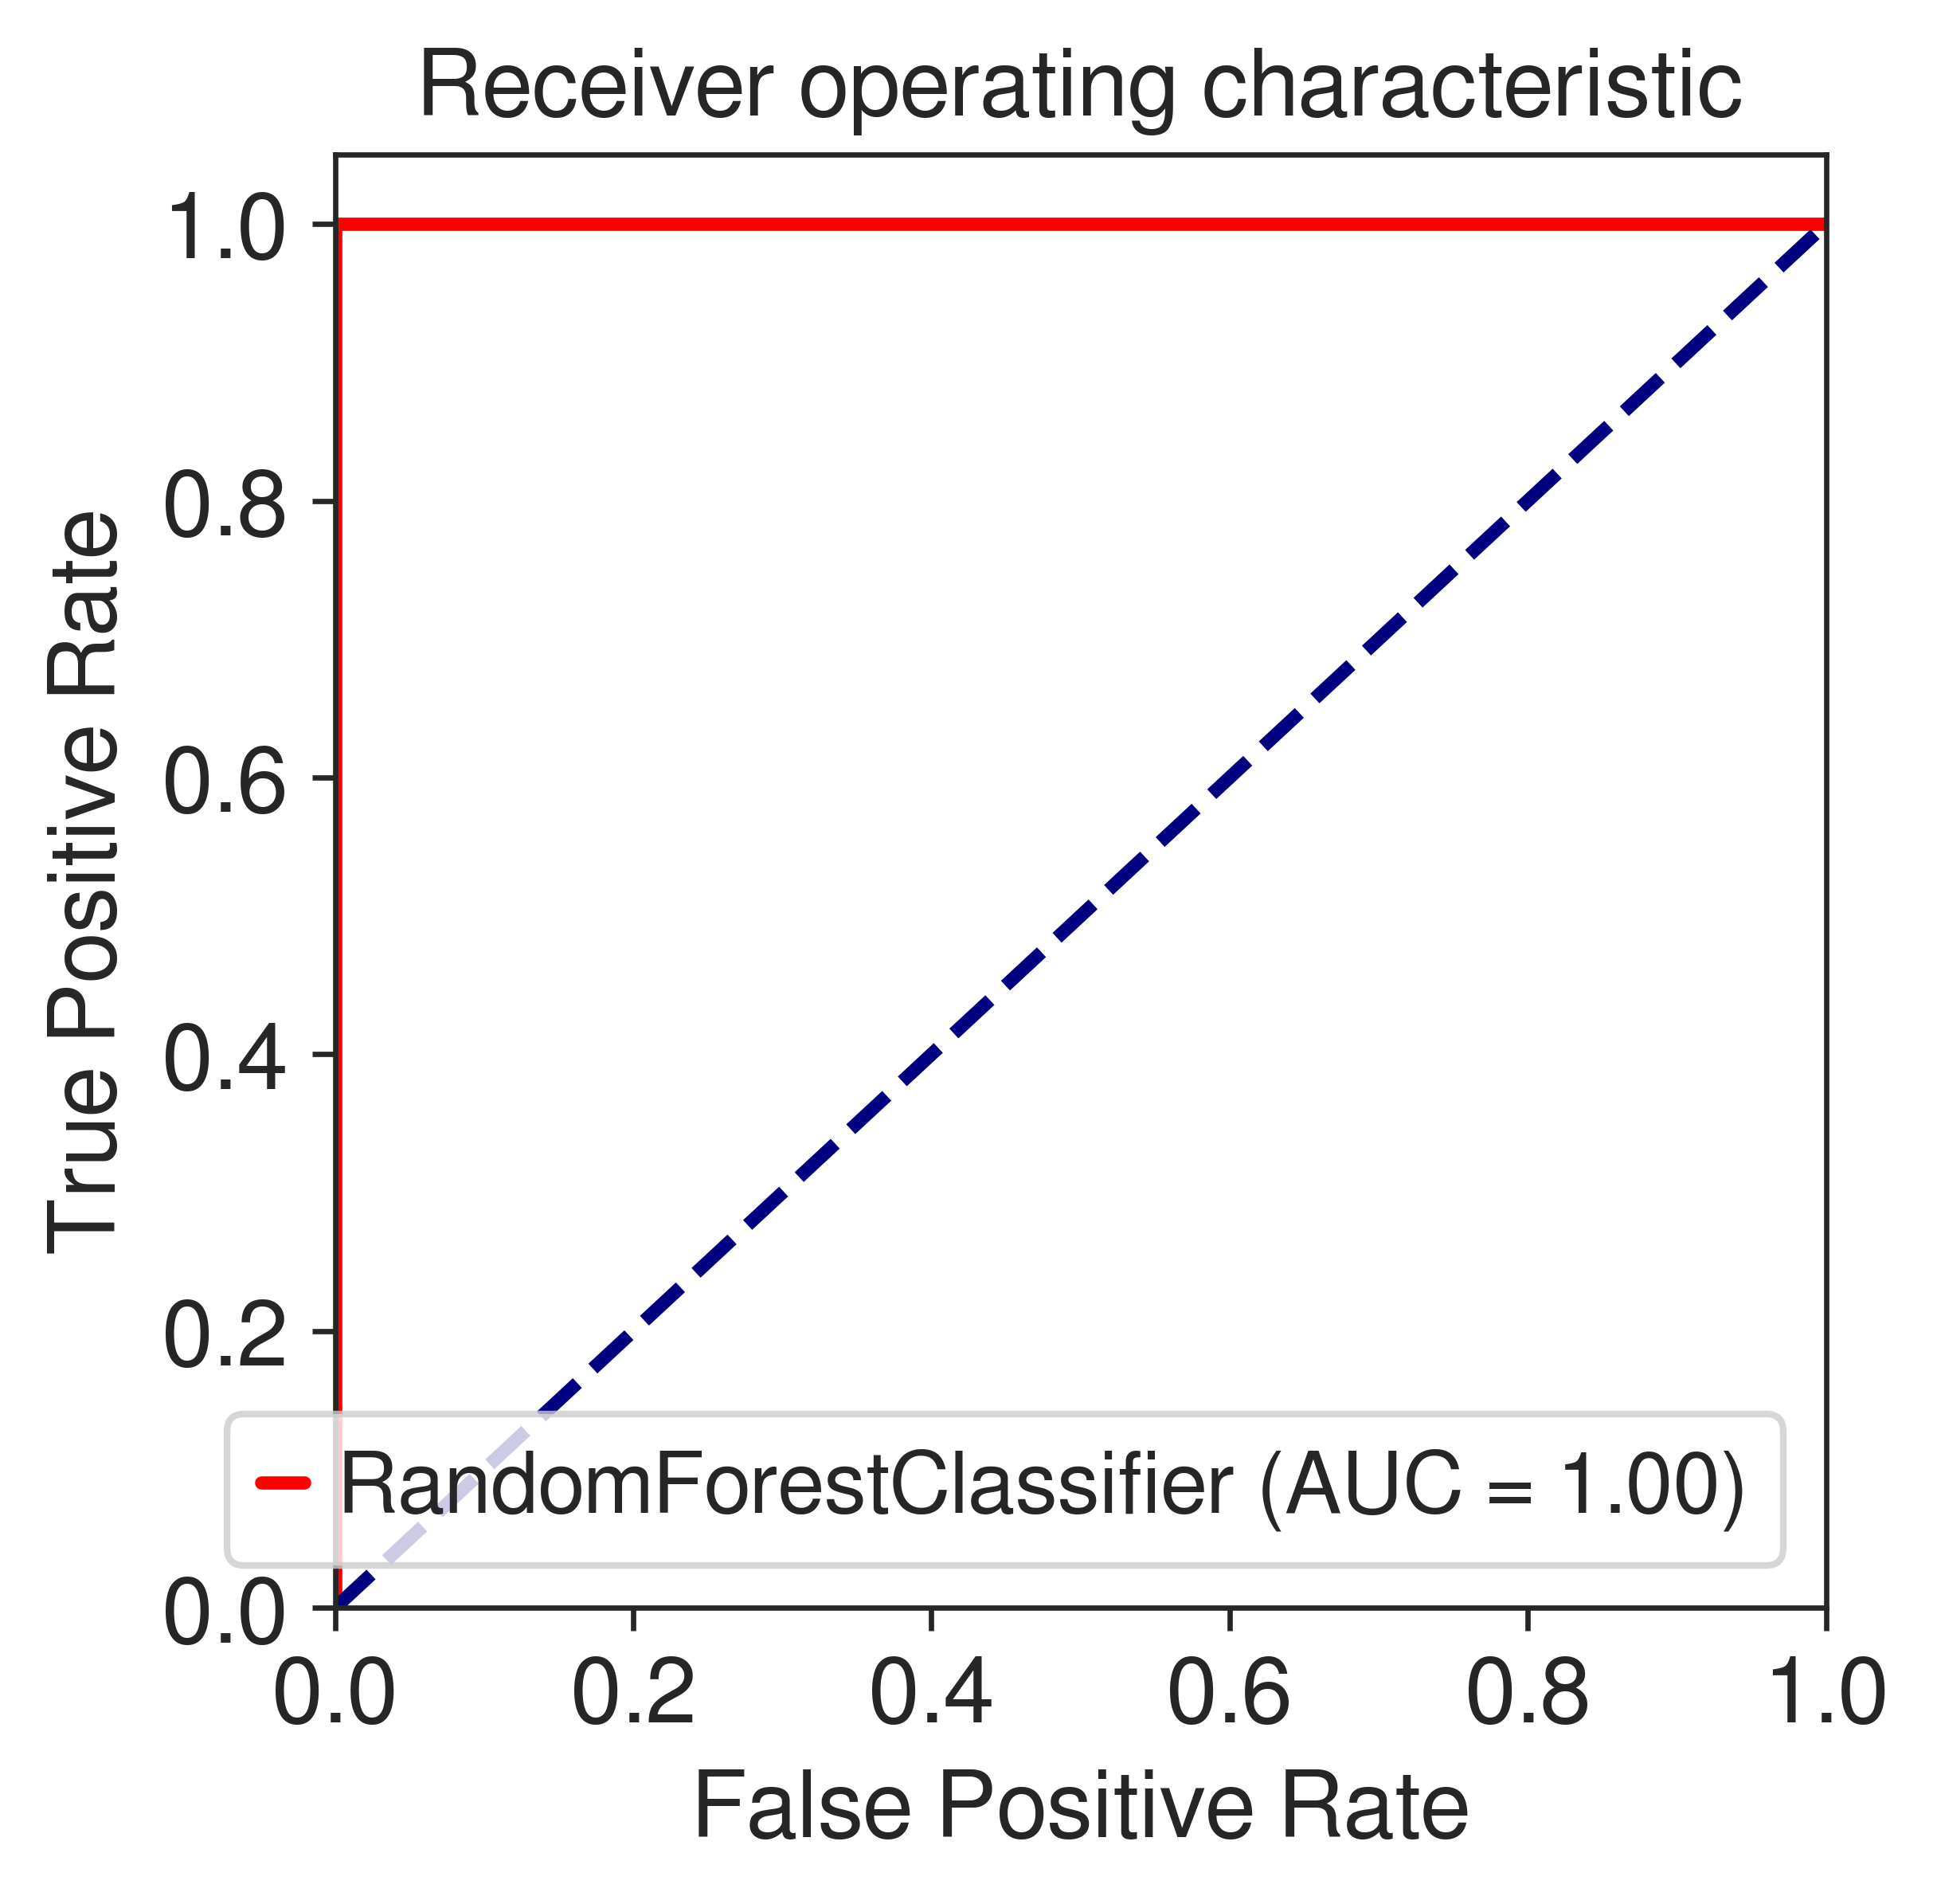

In [69]:
lw=2
plot_roc_curve(test_results.clf, test_results.X_test, test_results.y_test, 
               color='red', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(master_dir + 'output/sklearn/integrated_predictors_roc-train-new-210404.pdf')

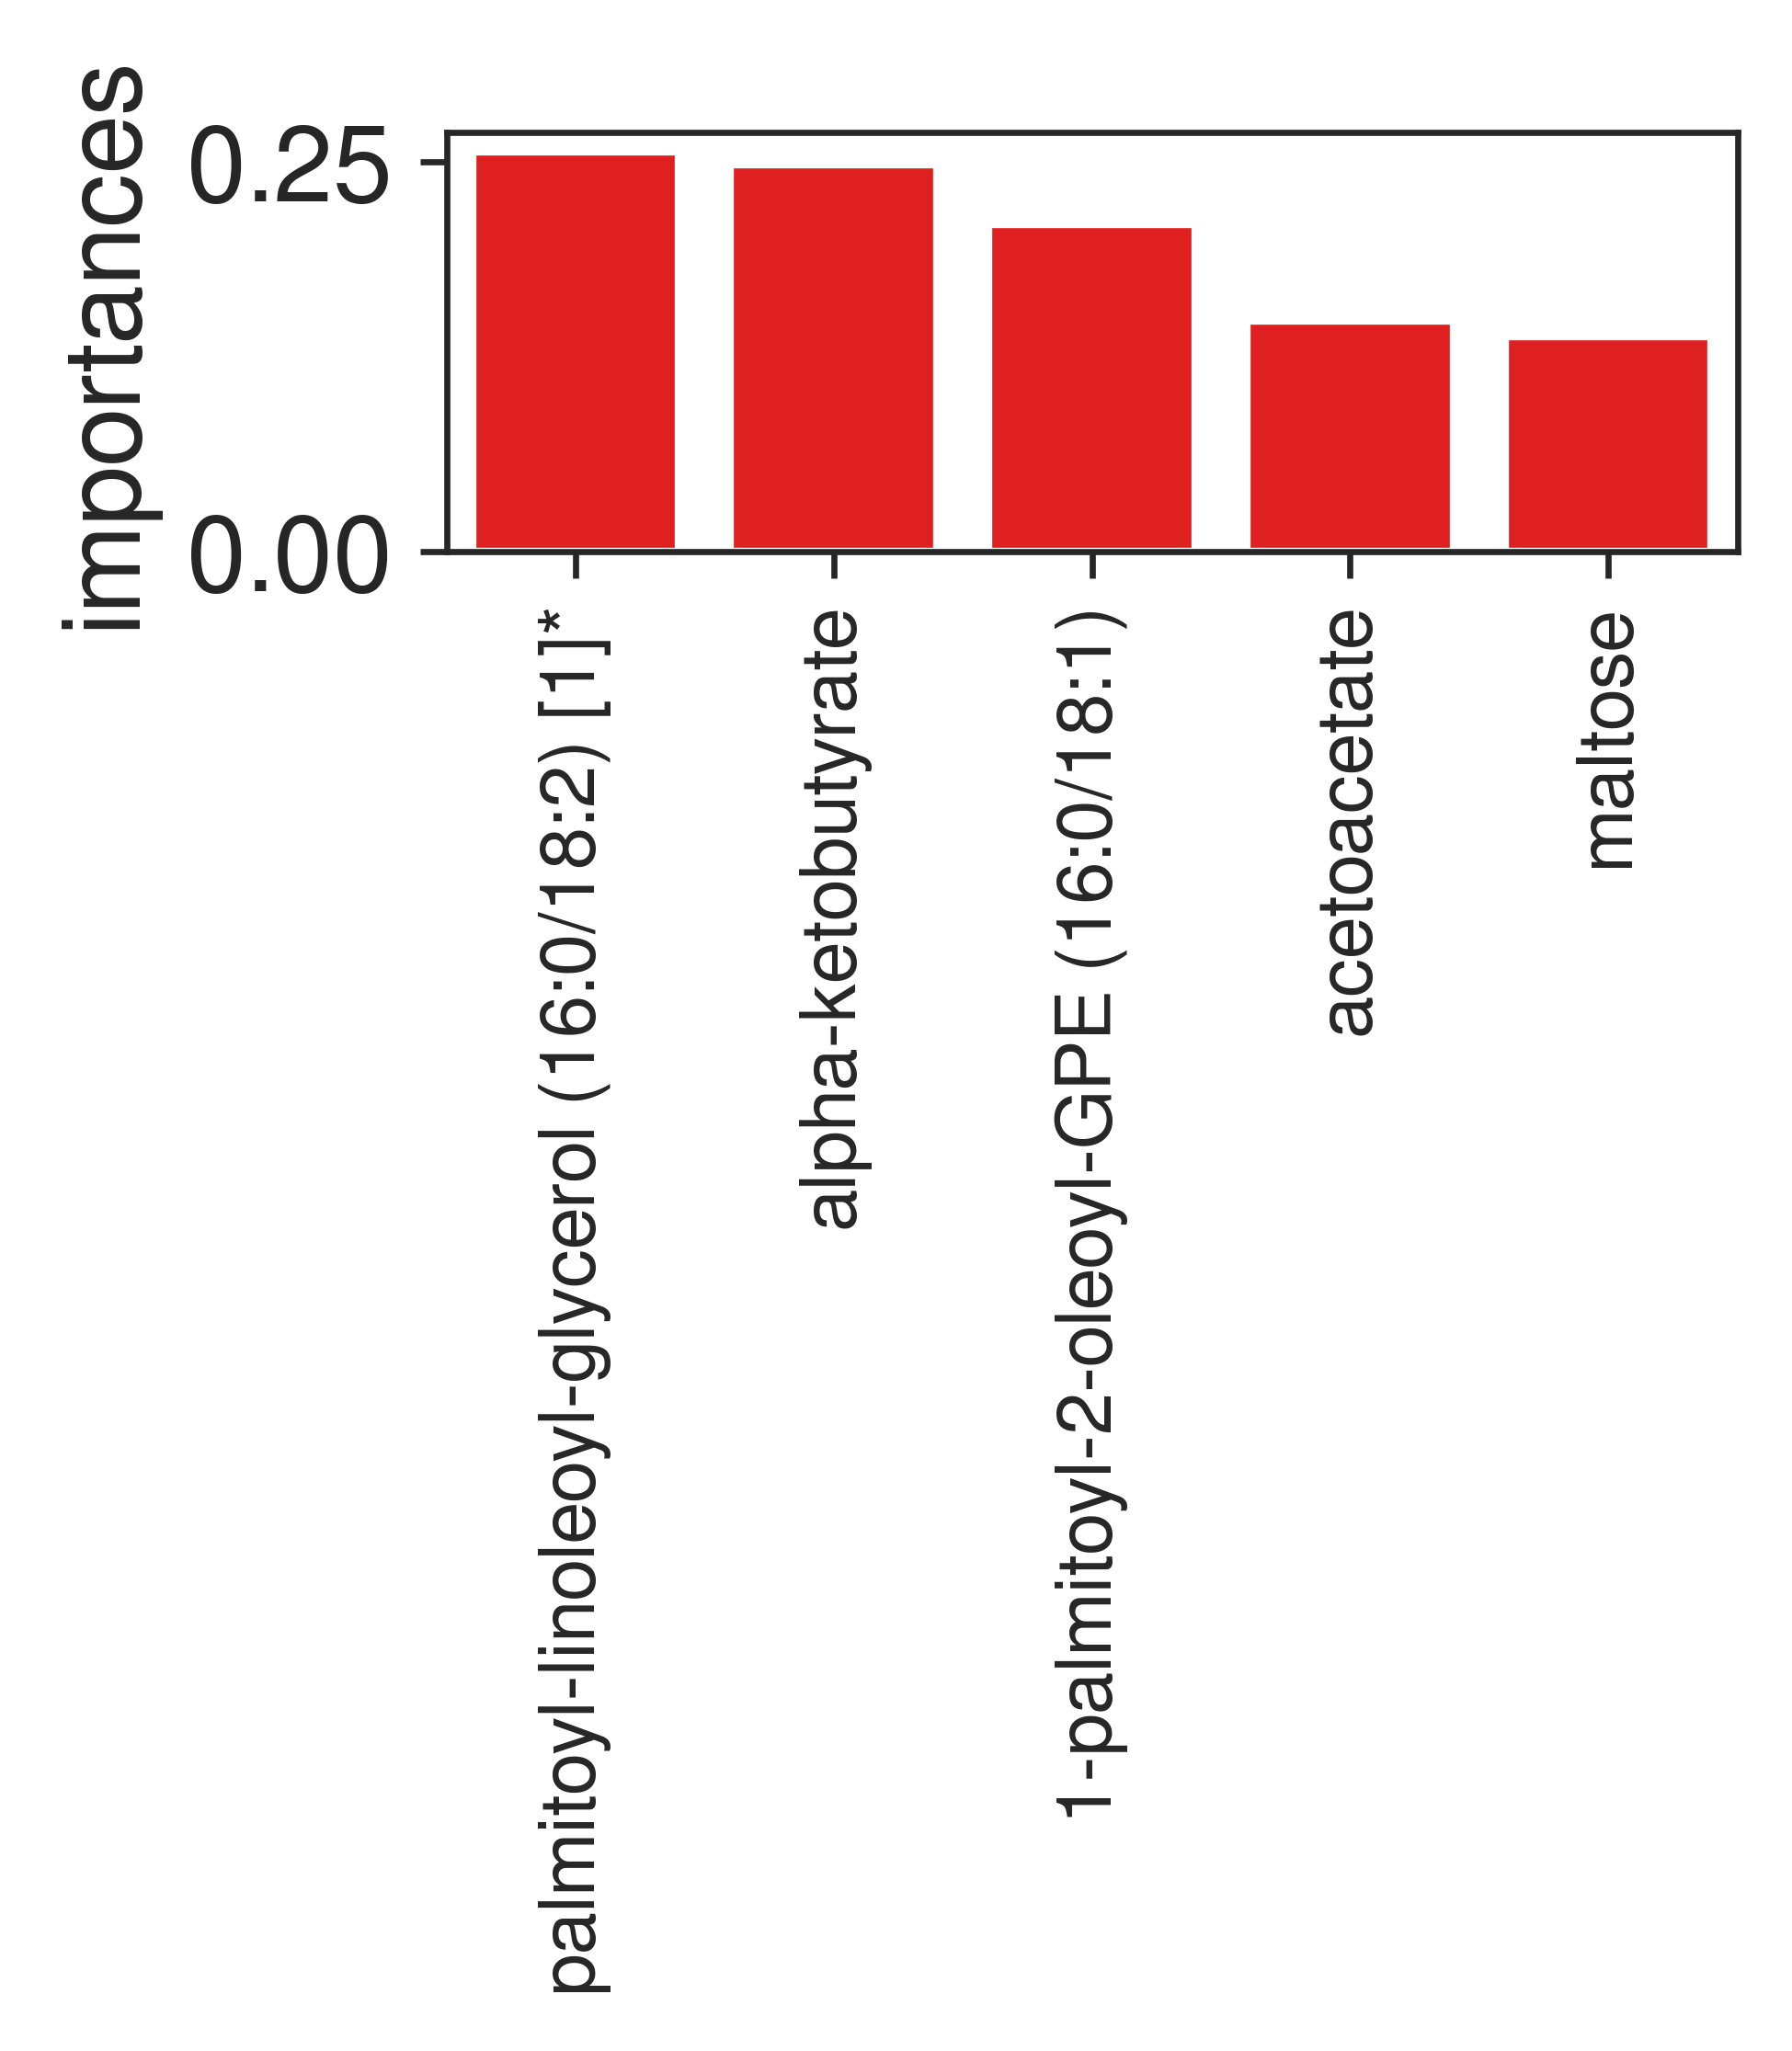

In [70]:
plt.figure(figsize=(3, 1))
importances = test_results.clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in test_results.clf.estimators_], axis=0)
#indices = np.where(input_t1.isin(test_results.selected_features))[0]
temp = pd.DataFrame(columns=['importances'])
temp['importances'] = importances
temp.index = test_results.selected_features
temp = temp.sort_values(by='importances', ascending=False)

f = sns.barplot(x=np.arange(len(temp.index)), y=temp['importances'], color='red')
plt.xticks(np.arange(len(temp.index)), temp.index, rotation=90, fontsize=10)
plt.savefig(master_dir + 'output/sklearn/integrated_predictors_importances-new-210404.pdf')

<ipython-input-71-fa9f260463db>:41: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(0),


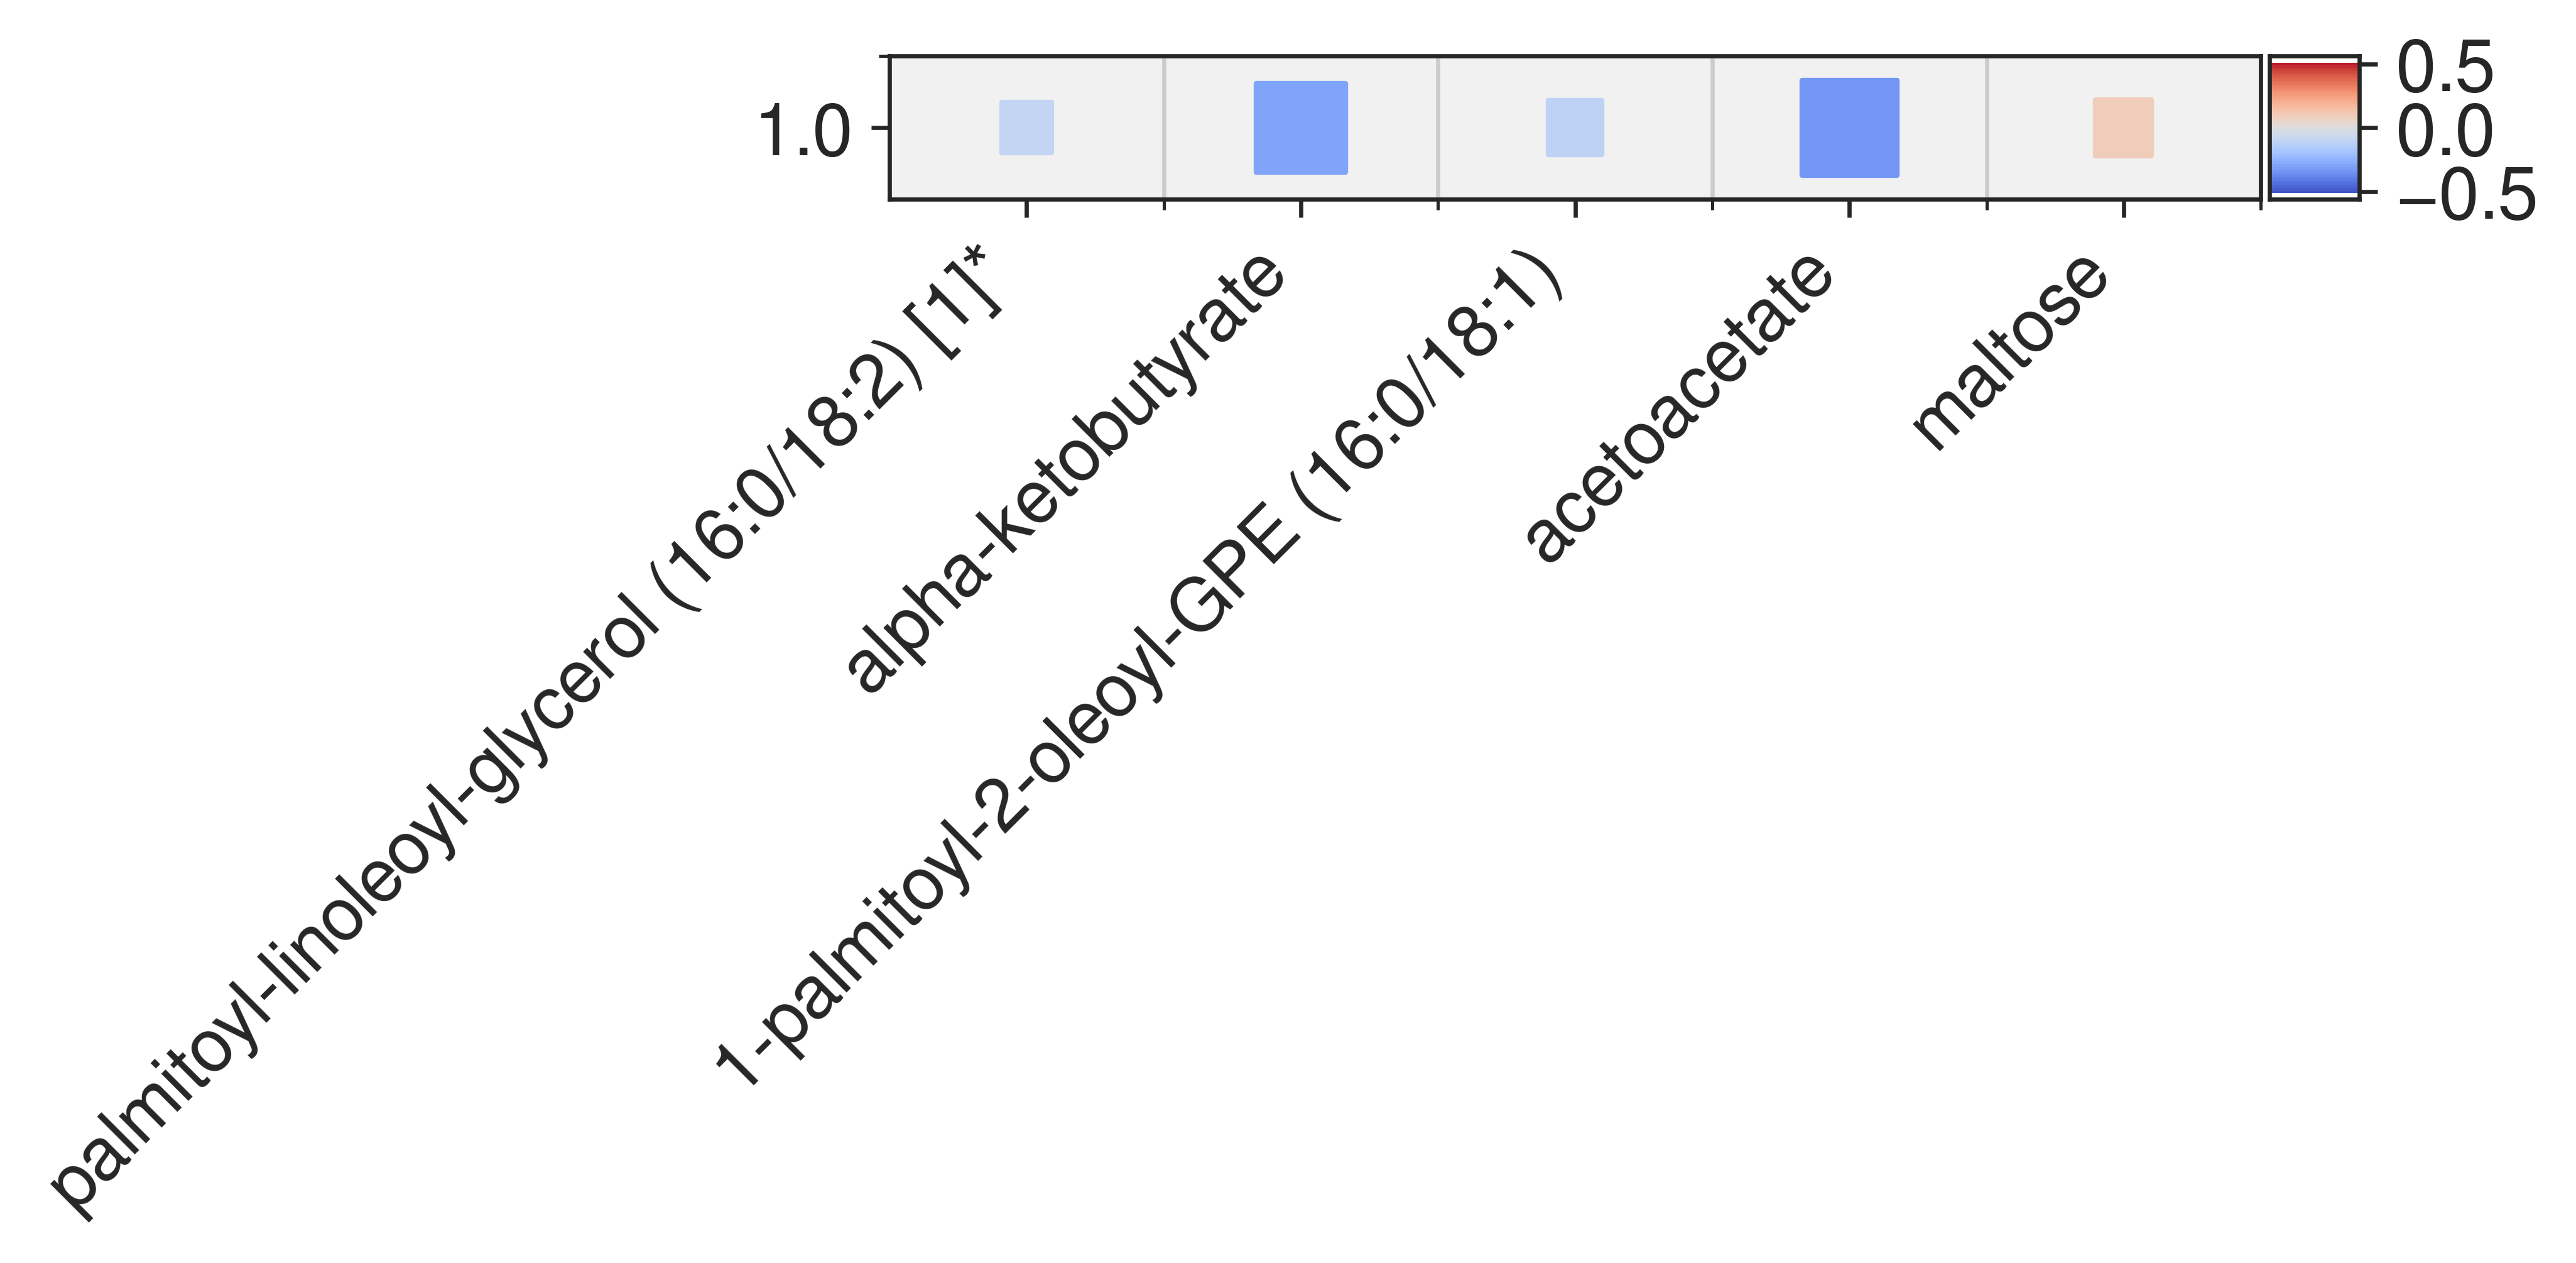

In [71]:
# Spearman correlation with the metabolites and first INCOV dataset
# Using the first INCOV dataset to show consistent correlation values with the rest of the paper

output_orig = adata.obs[adata.obs['who_change_cat']!='nan'][['blood_draw_type', 'who_change_cat', 'who_change']]
output_orig = output_orig[output_orig['blood_draw_type']=='Baseline']
output_orig['death'] = dead.reindex([x.split('-')[0] for x in output_orig.index])['death'].tolist()
output_orig['who_change_cat'] = ['Better/Stable' if x < 0 else 'Better/Stable' if x==0 
                            else 'Worse/Died' for x in output_orig['who_change']]

for i in output_orig.index:
    if output_orig.loc[i, 'death']=='Yes':
        output_orig.loc[i, 'who_change_cat'] = 'Worse/Died'
output_orig = output_orig.dropna(subset=['death'])['who_change']

input_orig_t1_pre = adata[output_orig.index]
input_orig_t1 = pd.DataFrame(input_orig_t1_pre.X, 
                columns=input_orig_t1_pre.var_names)[test_results.selected_features]
input_orig_t1.index = output_orig.index

df_predictors = pd.DataFrame(columns=['feature', 'Spearman_r', 'pvalue'])

features = test_results.selected_features
for i, feature in enumerate(features):
    temp = spearmanr(input_orig_t1.iloc[:, i], output_orig,
                    nan_policy='omit')
    df_predictors = df_predictors.append({'feature': feature, 'Spearman_r': temp[0], 'pvalue': temp[1]}, 
                                         ignore_index=True)

#sns.set_style('white')
f = plt.figure(figsize=(5, 0.5))
temp = df_predictors
temp['importance'] = test_results.clf.feature_importances_
temp = temp.sort_values(by='importance', ascending=False)
temp.index = temp['feature']
heatmap(x=temp.index, 
        y=np.ones(len(temp.index)), ylabel='', 
        color=temp['Spearman_r'], palette=sns.color_palette('coolwarm', n_colors=50),
        size=abs(temp['Spearman_r']),
        norm=DivergingNorm(0),
        color_range=[-0.5, 0.5],
        size_range=[0, 0.5],
        x_order=[x for x in temp.index])
plt.savefig(master_dir + 'output/sklearn/integrated_predictors_correlations-new-210404.pdf')

In [72]:
# Benjamini-Hochberg p value correction
temp['bh_pvalue'] = multipletests(temp['pvalue'], alpha=0.05, method='fdr_bh')[1]
temp

,feature,Spearman_r,pvalue,importance,bh_pvalue
feature,,,,,
palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*,palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*,-0.087321,0.407851,0.256269,0.407851
alpha-ketobutyrate,alpha-ketobutyrate,-0.285518,0.005534,0.248300,0.019073
1-palmitoyl-2-oleoyl-GPE (16:0/18:1),1-palmitoyl-2-oleoyl-GPE (16:0/18:1),-0.101464,0.327885,0.209885,0.407851
acetoacetate,acetoacetate,-0.328084,0.007629,0.147700,0.019073
maltose,maltose,0.110385,0.355965,0.137847,0.407851


Testing on the JWCI dataset

In [ ]:
# Test the previously trained model on the JWCI dataset
# If reapplying same model without retraining
output_JWCI = pd.Series(dead_JWCI['death'])

# Separate majority and minority classes
output_majo = output_JWCI[output_JWCI=='No']
output_mino = output_JWCI[output_JWCI=='Yes']
 
# Resample minority class (dead) to fixed fraction of majority class (surviving)
output_mino_resampled = resample(output_mino, replace=True, n_samples=int(len(output_majo)/5), random_state=0)
 
# Combine majority class with resampled minority class
output_JWCI_resampled = pd.concat([output_majo, output_mino_resampled])

input_t1_pre_JWCI = impute_input(adata_JWCI, output_JWCI, output_JWCI_resampled)

input_t1_JWCI = model.transform(input_t1_pre_JWCI)

X_train_JWCI, X_test_JWCI, y_train_JWCI, y_test_JWCI = model_selection.train_test_split(input_t1_JWCI, 
                                                                output_JWCI_resampled, 
                                                                test_size=0.95, random_state=0)

test_results_JWCI = train_test(pre_clf, selected_features, clf, X_train_JWCI, input_t1_JWCI, 
                               y_train_JWCI, output_JWCI_resampled, 
                              clf.predict(input_t1_JWCI), clf.score(input_t1_JWCI, output_JWCI_resampled))

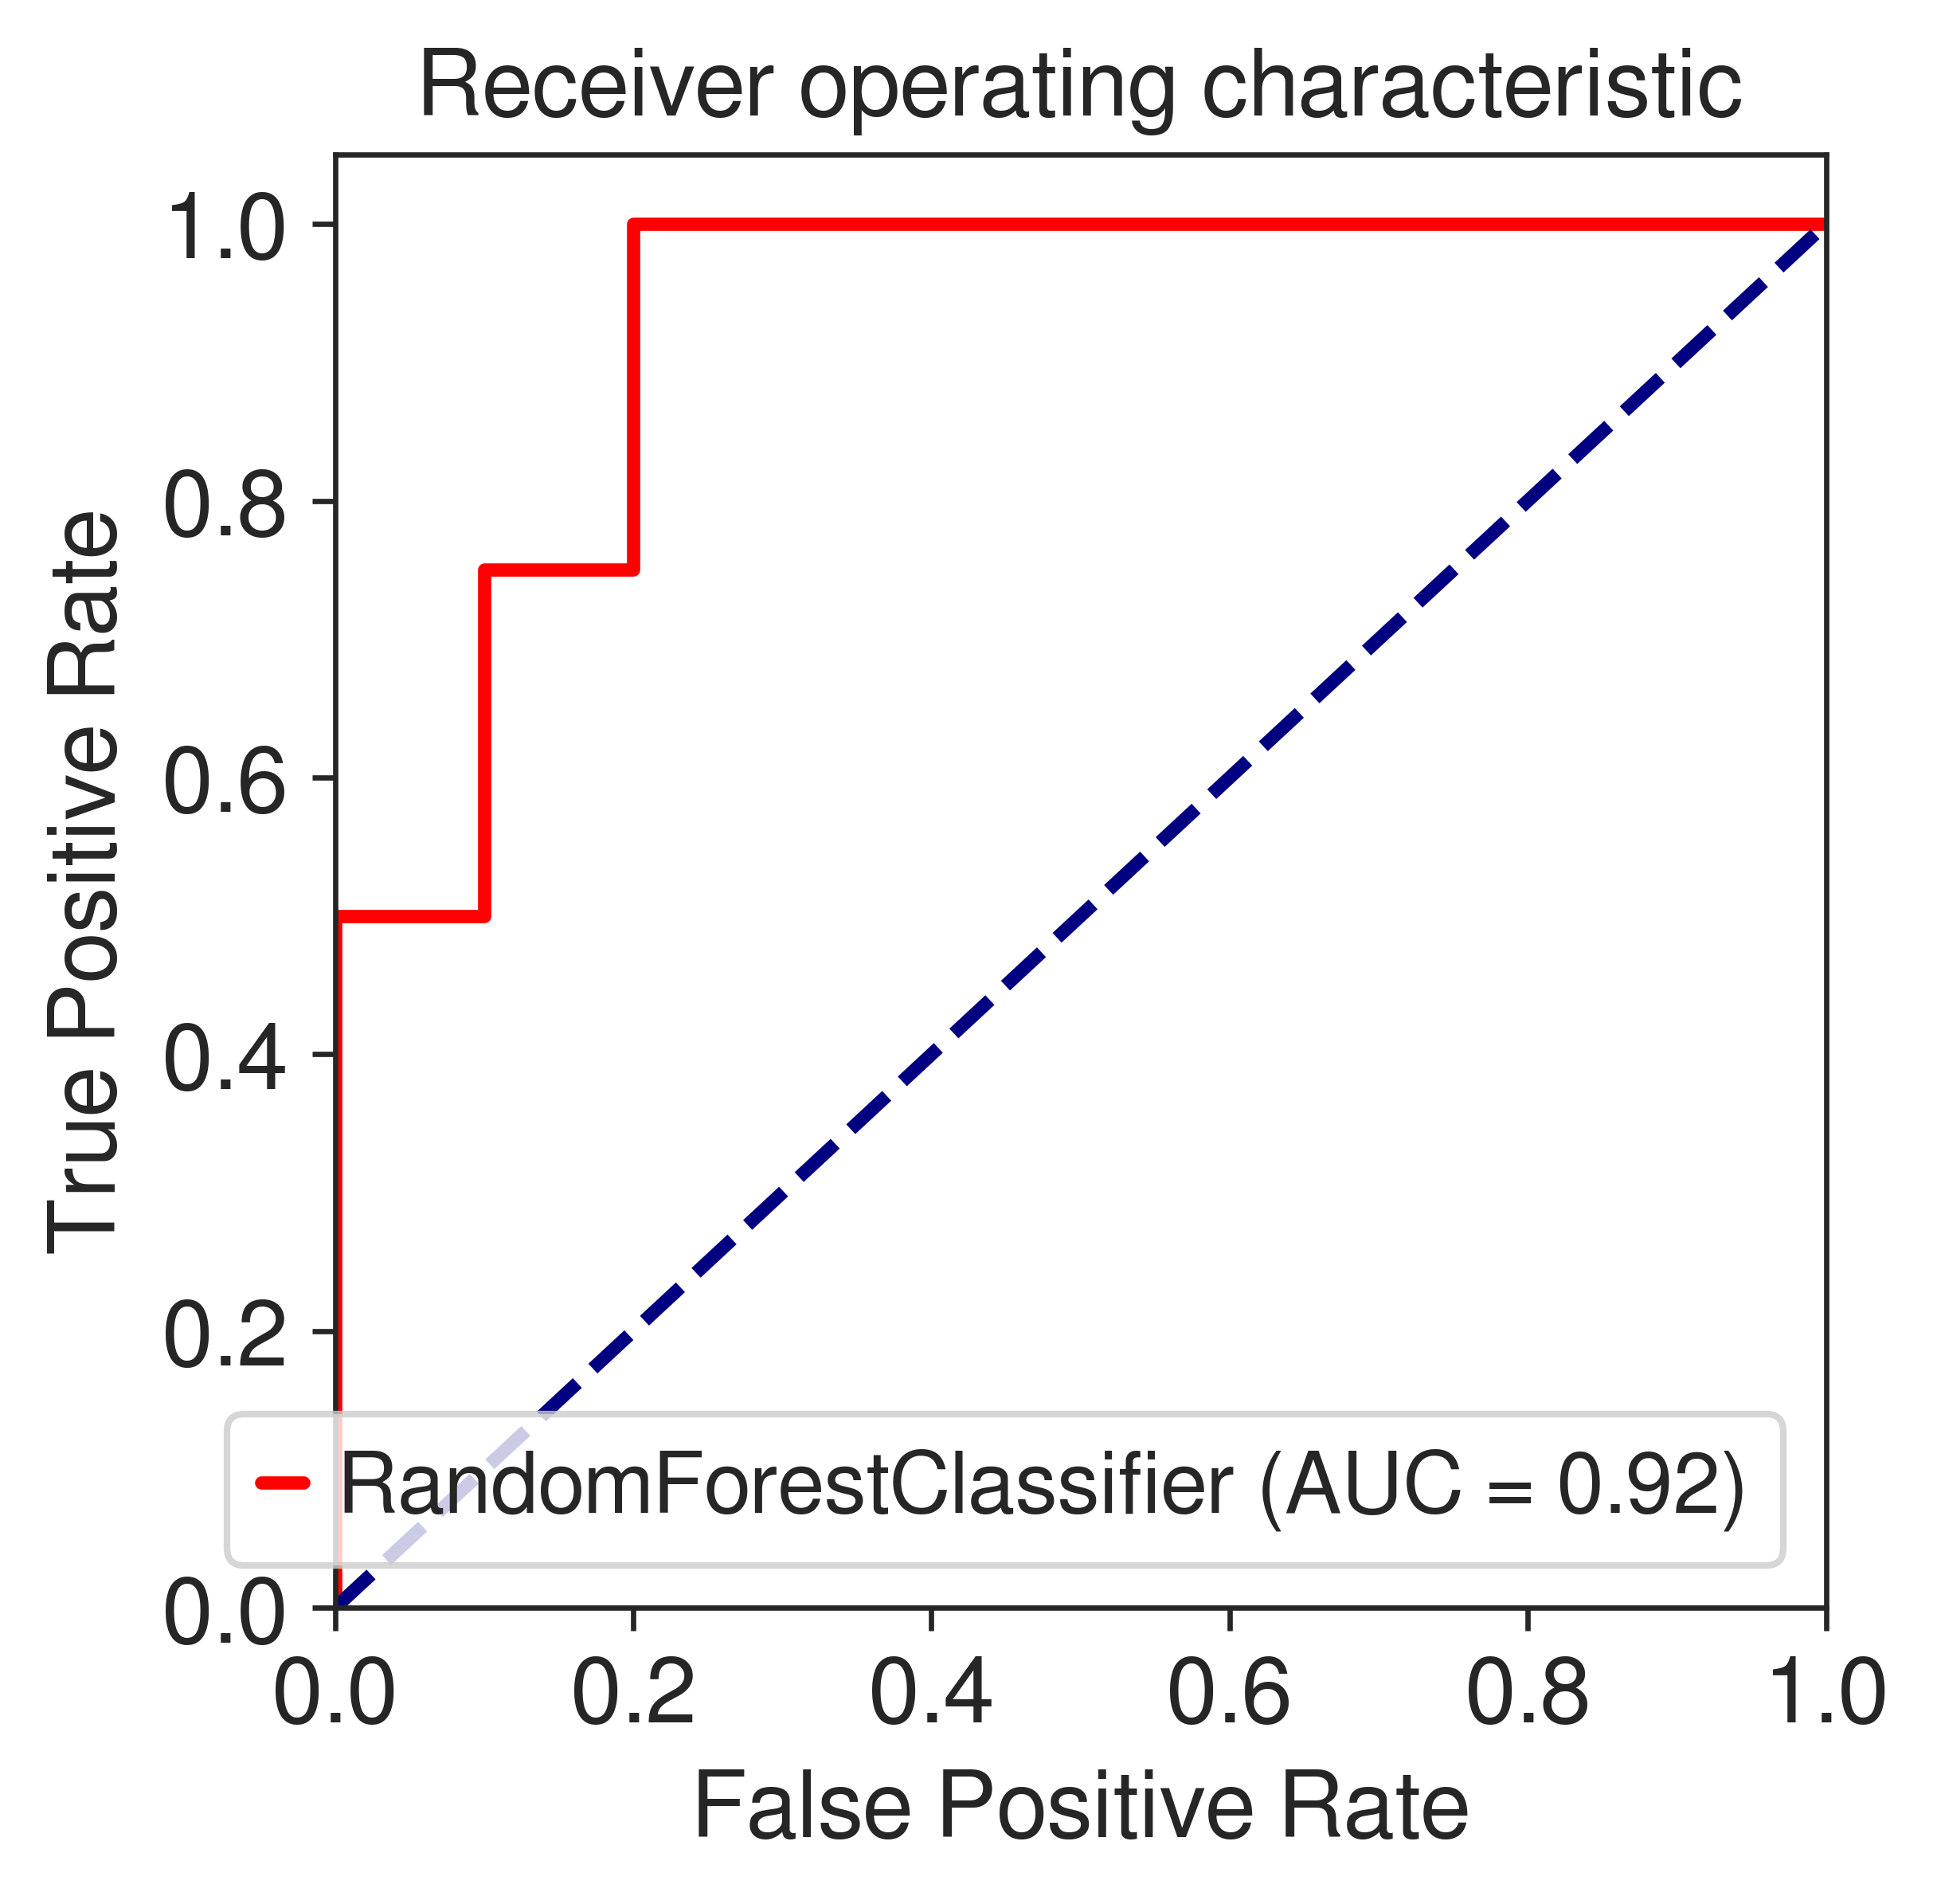

In [74]:
lw=2
plot_roc_curve(test_results_JWCI.clf, test_results_JWCI.X_test, test_results_JWCI.y_test, 
               color='red', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(master_dir + 'output/sklearn/integrated_predictors_roc-test-new-JWCI-210404.pdf')

Going back to the INCOV dataset and rerunning new training with different splits, then retesting each of those randomized fits on JWCI dataset again

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

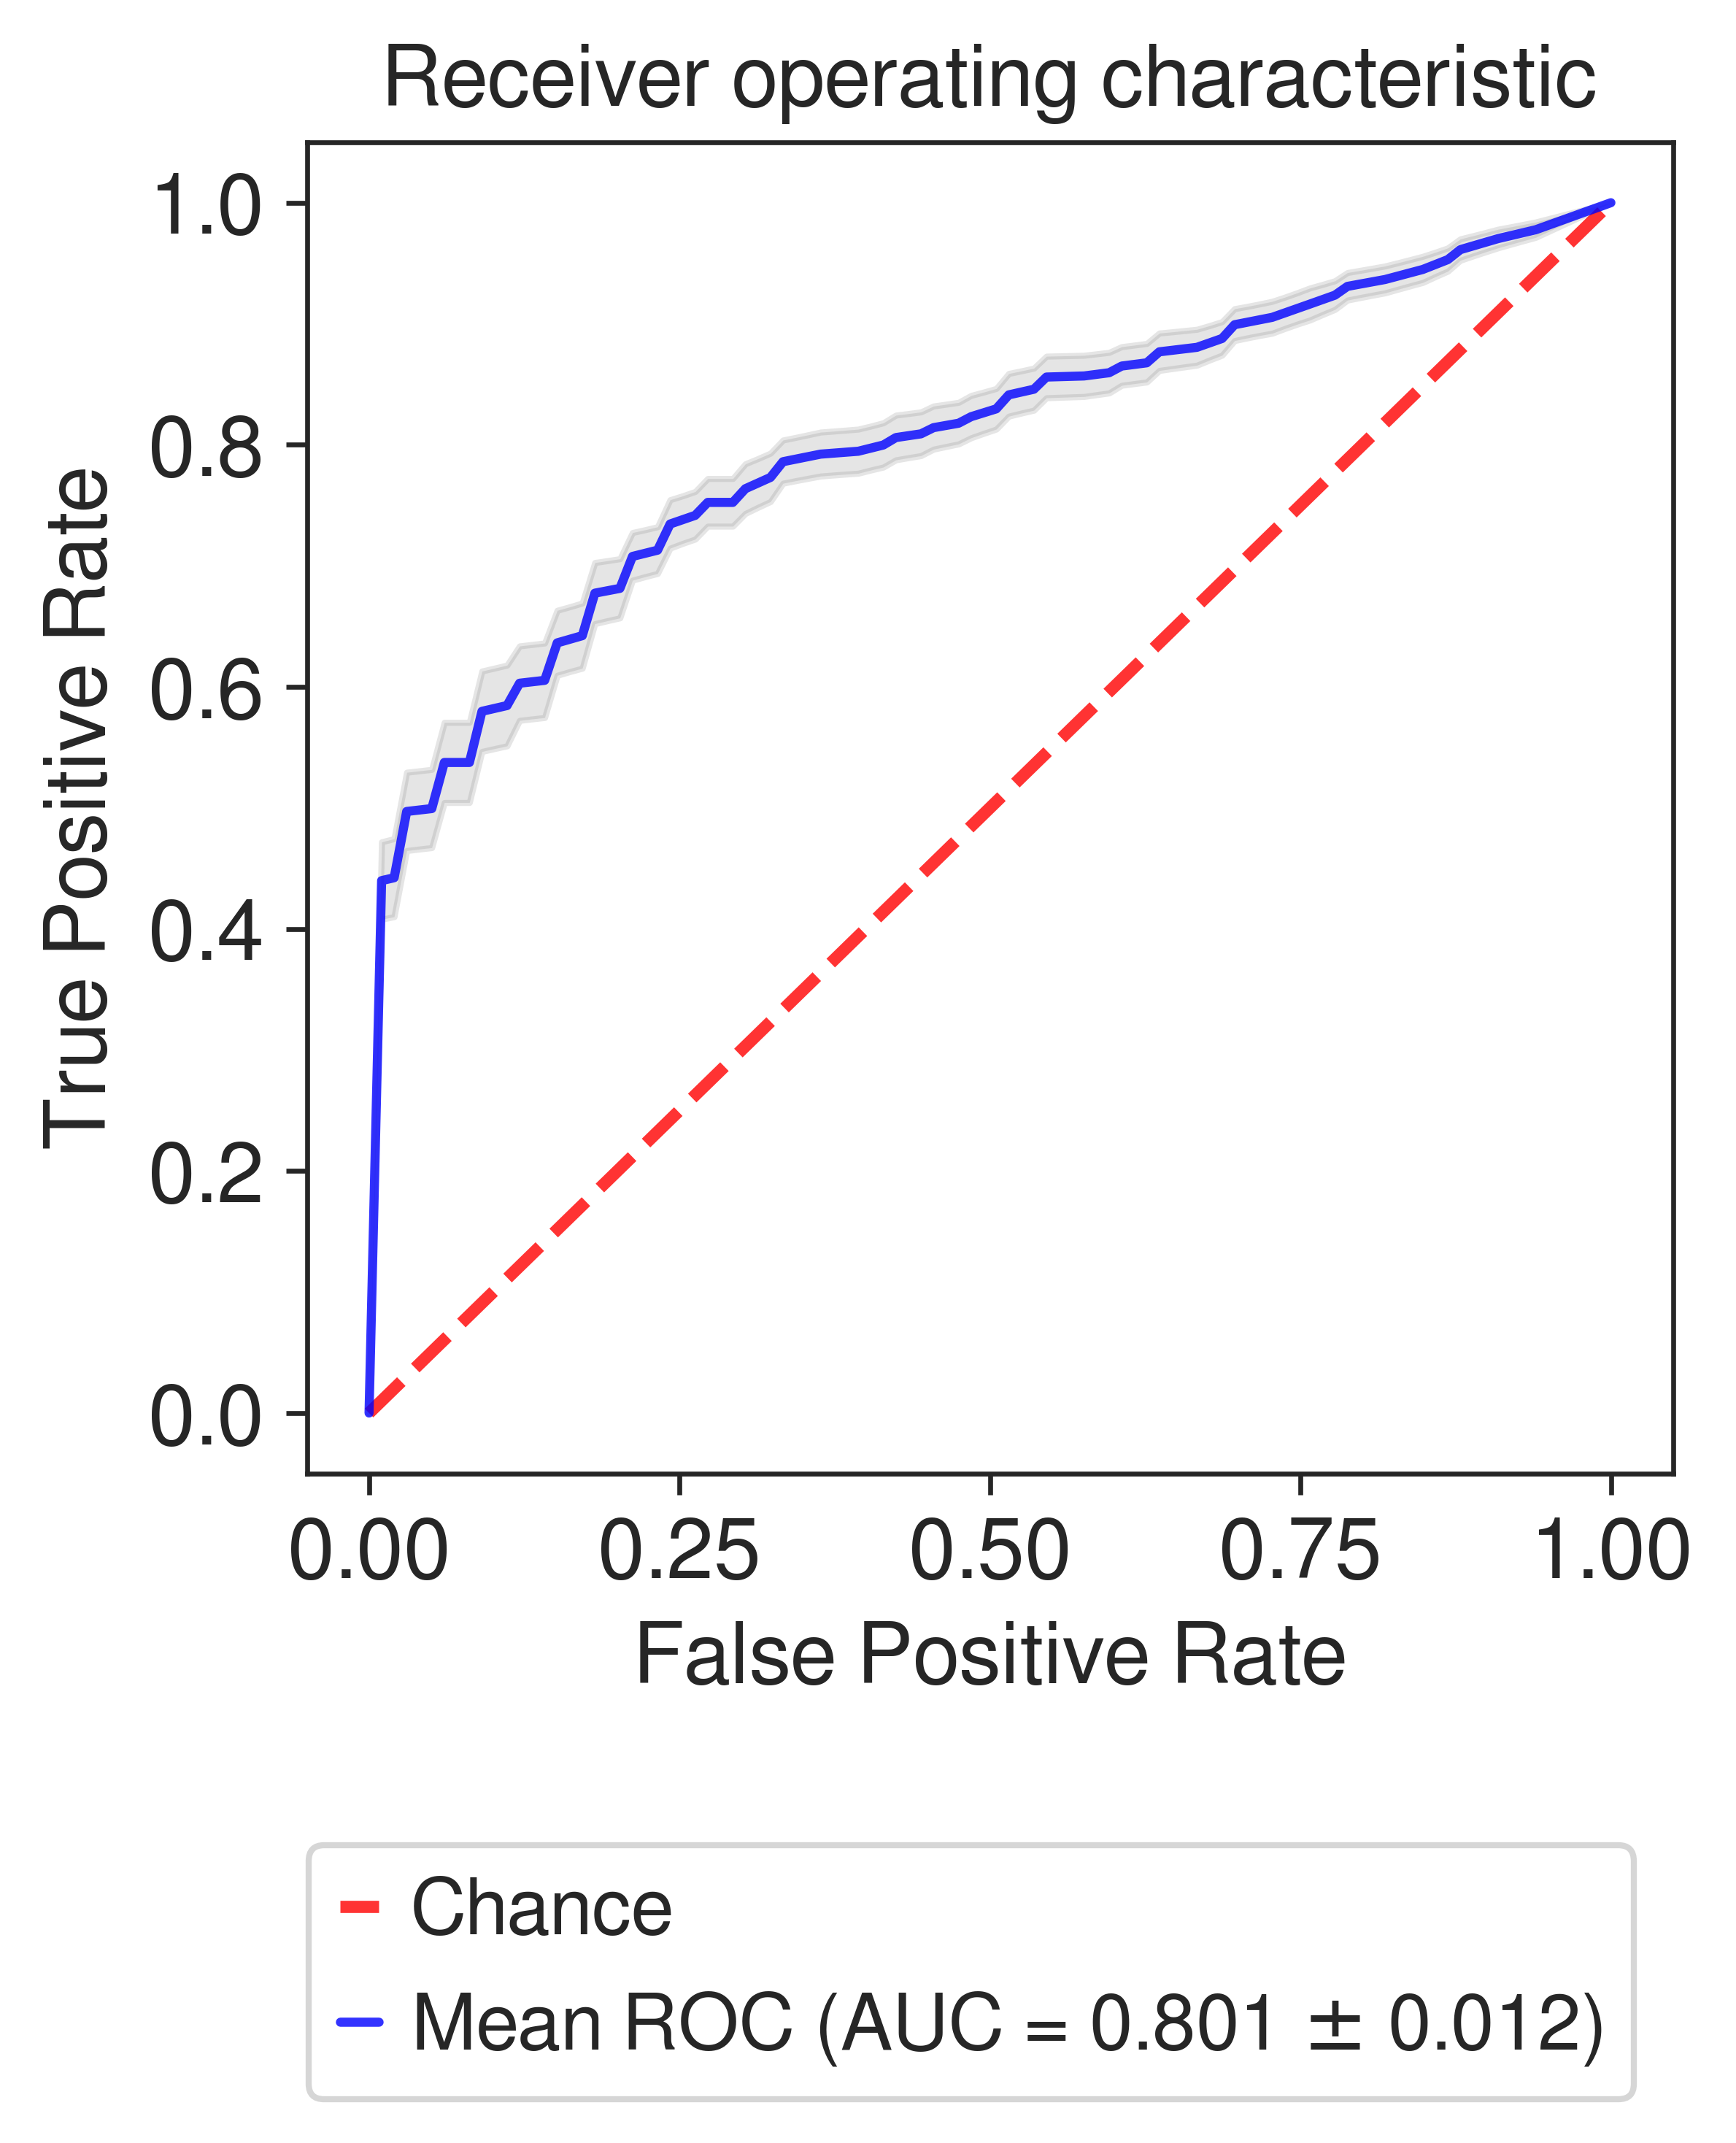

In [131]:
# Run classifier with cross-validation and plot ROC curves (training set)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=20, random_state=2)

tprs = []
aucs = []
clfs_temp = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(input_t1, output_resampled)):
    clf.fit(input_t1[train], output_resampled[train])
    viz = plot_roc_curve(clf, input_t1[test], output_resampled[test], label=None,
                         alpha=0.0, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    clfs_temp.append(clf)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc / 40**0.5),
        lw=1.5, alpha=.8)

std_tpr = np.std(tprs, axis=0) / 40**0.5 # Using standard error
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2,
                label=None)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(bbox_to_anchor=(1, -0.25))

plt.savefig(master_dir + 'output/sklearn/integrated_predictors_roc-agg-train-new-210404-2.pdf', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

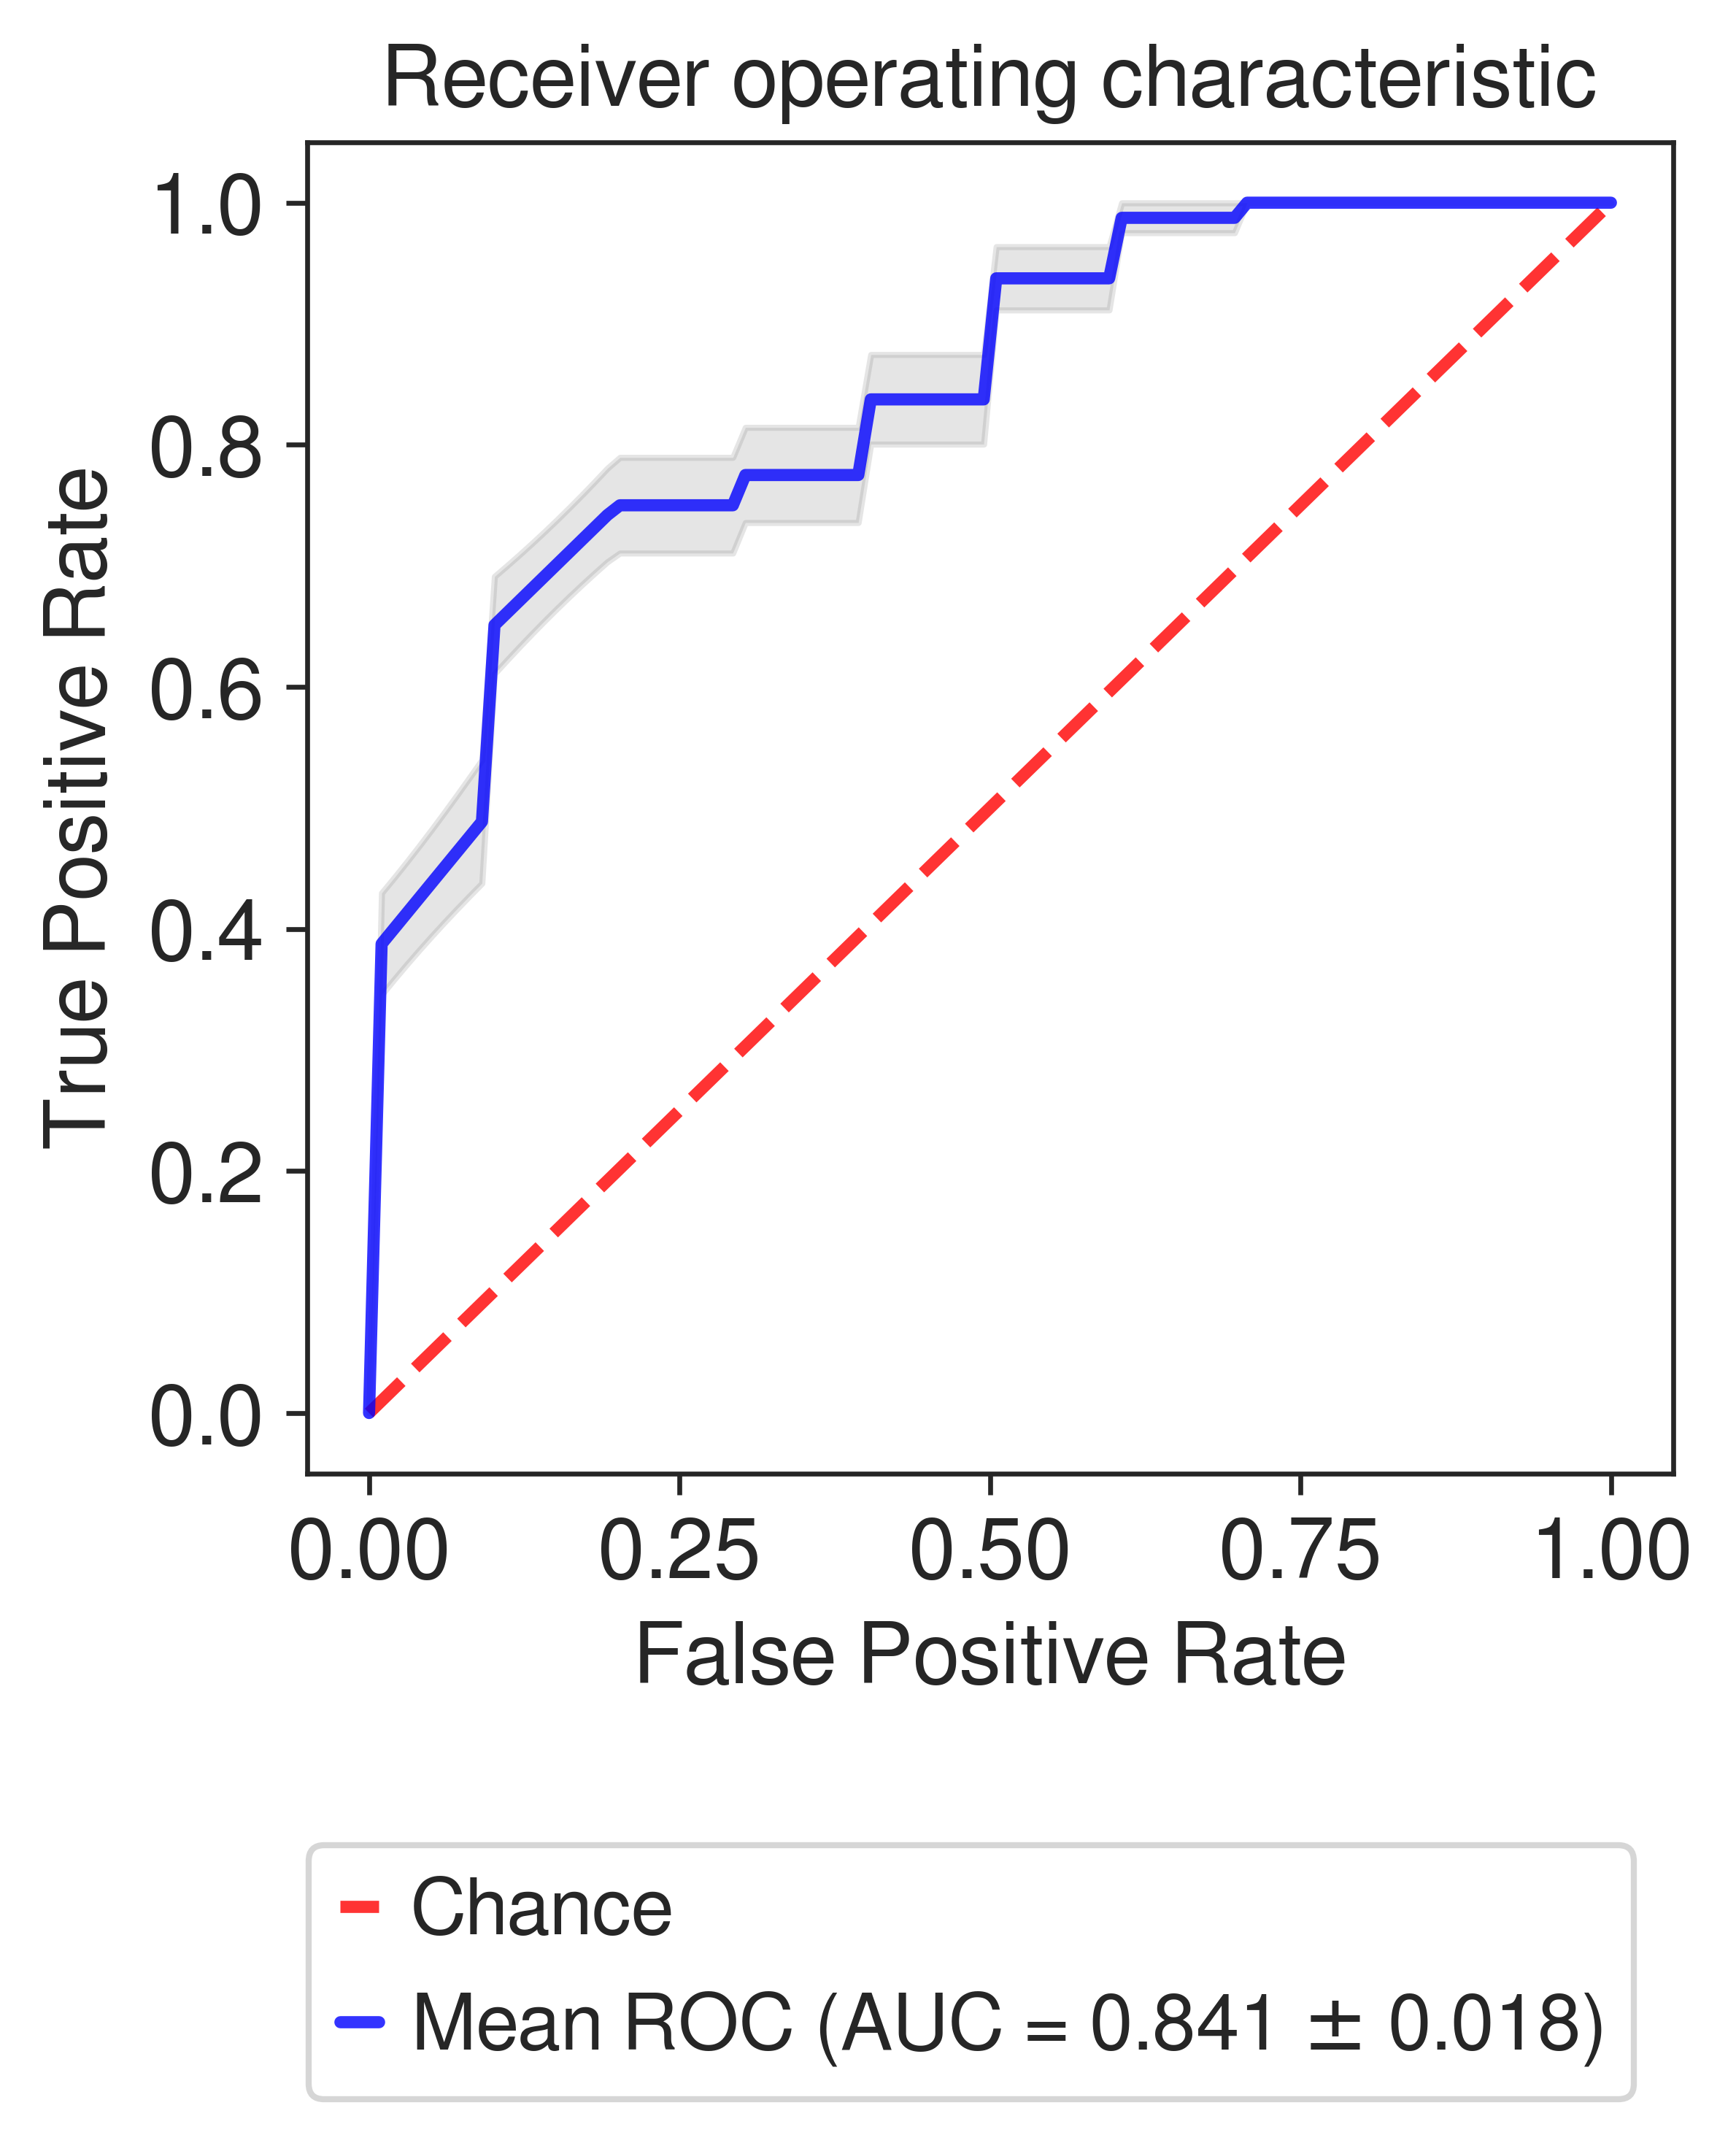

In [130]:
# Run the above cross-trained classifiers on the JWCI dataset to test
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(input_t1_JWCI, output_JWCI_resampled)):
    clf = clfs_temp[i]
    viz = plot_roc_curve(clf, input_t1_JWCI[test], output_JWCI_resampled[test], label=None,
                         alpha=0, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc / 40**0.5),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0) / 40**0.5
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2,
                label=None)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(bbox_to_anchor=(1, -0.25))

plt.savefig(master_dir + 'output/sklearn/integrated_predictors_roc-agg-test-new-JWCI-210404-2.pdf', bbox_inches='tight')

## Patient dataset QC

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing PCA
    with n_comps=19
    finished (0:00:00)


... storing 'death' as categorical
... storing 'JWCI' as categorical
... storing 'patient_location' as categorical


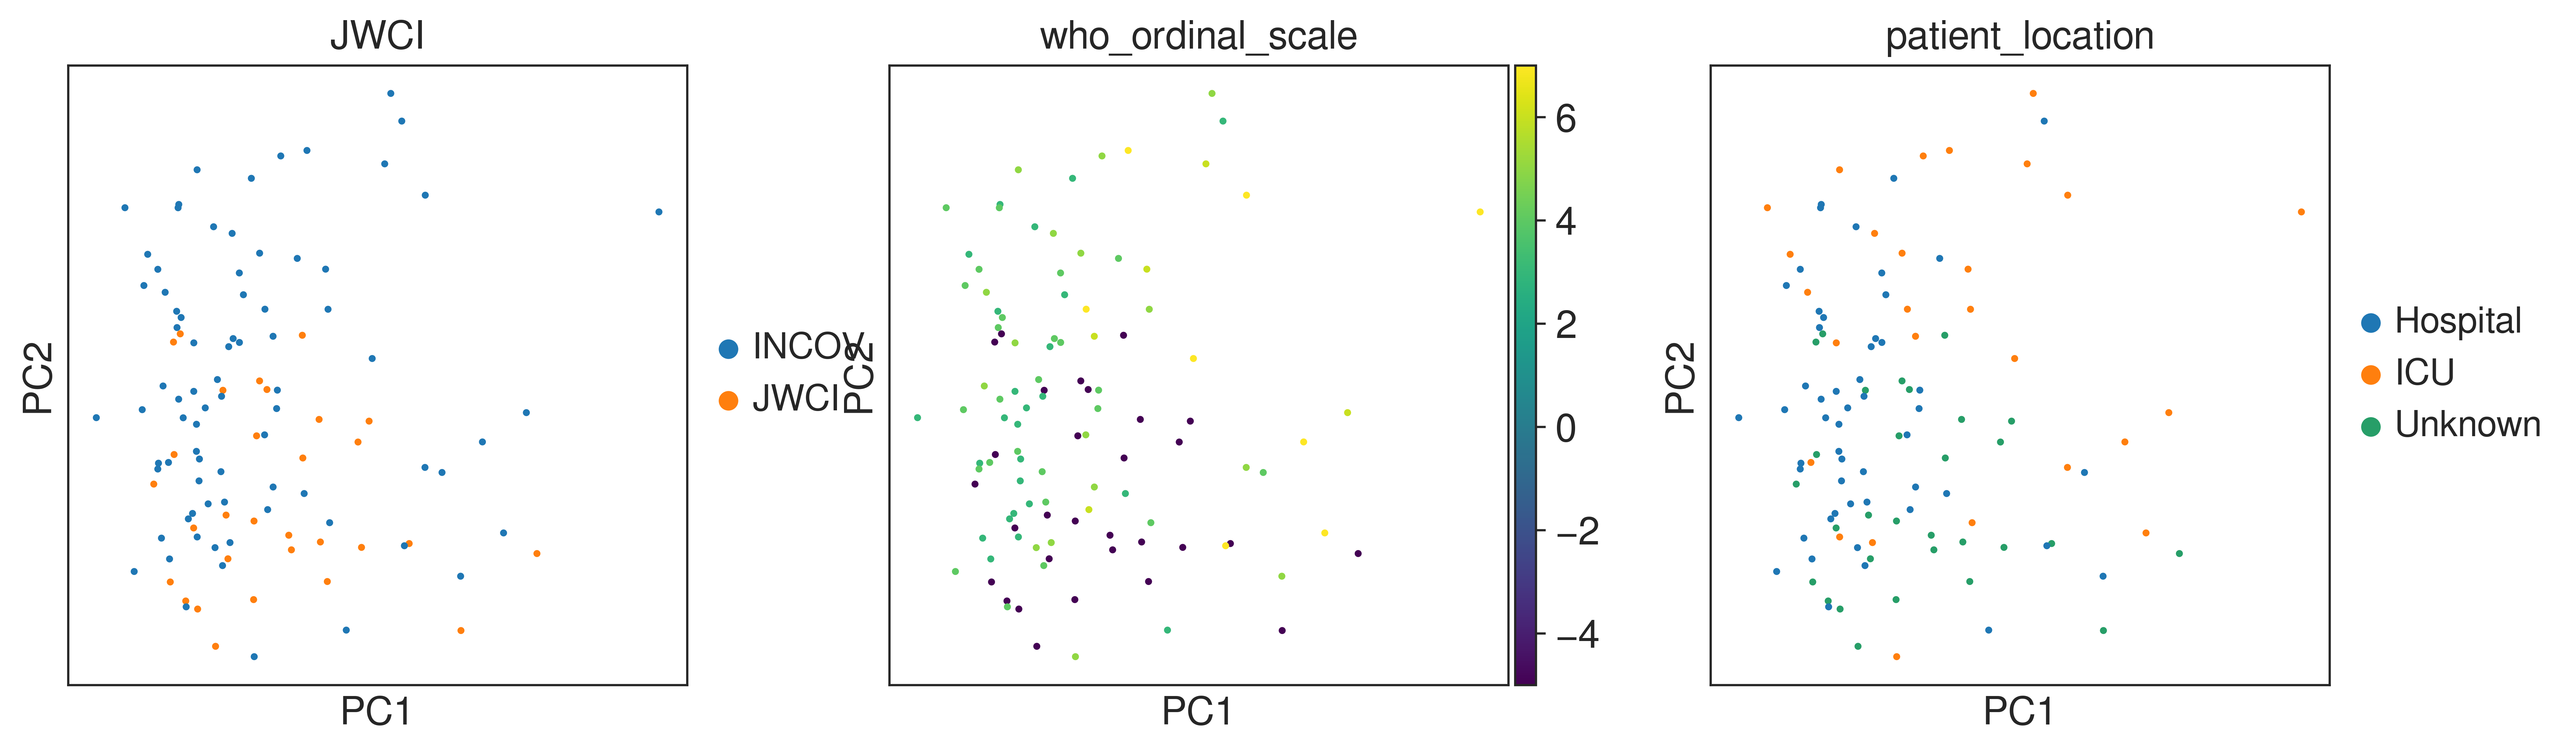

In [78]:
adata_JWCI_test = adata_JWCI.copy()
adata_JWCI_test.obs['JWCI'] = 'JWCI'
adata_JWCI_test.obs['who_ordinal_scale'] = -5
adata_JWCI_test.obs['patient_location'] = 'Unknown'
adata_comb.obs['JWCI'] = 'INCOV'
adata_comb.obs['death'] = output_comb
adata_JWCI_test = sc.concat([adata_JWCI_test, adata_comb], keys=['JWCI', 'INCOV'])[:, PCA_list]

adata_JWCI_test.X = np.nan_to_num(adata_JWCI_test.X)
tempX = (adata_JWCI_test.X - np.mean(adata_JWCI_test.X, axis=0)) / \
        (np.max(adata_JWCI_test.X, axis=0) - np.min(adata_JWCI_test.X, axis=0)) 

adata_JWCI_test.X = tempX
adata_JWCI_test.X = np.nan_to_num(adata_JWCI_test.X)

sc.pp.neighbors(adata_JWCI_test)
sc.tl.pca(adata_JWCI_test)
sc.pl.pca(adata_JWCI_test, color=['JWCI', 'who_ordinal_scale', 'patient_location'], size=25, cmap='viridis')